In [1]:
import sys
print(sys.executable)

/Users/rafael/miniforge3/envs/rsrch-env/bin/python


In [2]:
#!pip install camb
#!python -m pip install corner
#already did this, had to install it in a new created enviroment "camb-env" <-- (Should appear in dir output above)

In [4]:
import corner
print(corner.__version__)

2.2.3


In [5]:
#!pip install pandas

In [6]:
# Timing a single line of code
import time 

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import platform, os

from matplotlib import pyplot as plt
import numpy as np
## NO NEED NOW!!!!
#import camb
#from camb import model, initialpower

import healpy as hp

#print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

## Data CMB

In [9]:
import pymaster as nmt

In [10]:
mask = hp.read_map("HFI_Mask_GalPlane-apo2_2048_R2.00.fits", field = 3) # we select the 'GAL070  ' 

In [11]:
f_hm1 = nmt.NmtField(mask, [hp.read_map("COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=0)])
f_hm2 = nmt.NmtField(mask, [hp.read_map("COM_CMB_IQU-smica_2048_R3.00_hm2.fits", field=0)])

In [12]:
nside = hp.npix2nside(len(mask))  #  nside x nside = number of pixels in one of the 12 partitions of the sphere
lmax = 3*nside-1
print(lmax)

6143


In [13]:
delta_ell = 25

In [14]:
b = nmt.NmtBin.from_nside_linear(nside, 25)

In [15]:
%%time
# Compute MASTER estimator of pseudo-Cls
cb_00 = nmt.compute_full_master(f_hm1, f_hm2, b)   # spin-0 x spin-0

# Computes the pseudo-𝐶ℓ (from masked data)
# Computes the mode-coupling matrix 𝑀ℓℓ′ 
# Inverts it (or corrects for it numerically)
# Returns the unbiased estimate of 𝐶ℓ

CPU times: user 16min 37s, sys: 15.9 s, total: 16min 53s
Wall time: 2min 34s


In [16]:
cb = cb_00[0]*1e12 # passing from kelvin squared to microkelvin squared

In [17]:
ell_arr = b.get_effective_ells()

### getting weighted $\ell_b$

In [18]:
bin_edges = ell_arr - int(0.5*delta_ell) # - 12
bin_edges = np.append(bin_edges, [ell_arr[-1]+int(0.5*delta_ell)])

In [19]:
def compute_ell_b_from_edges(bin_edges):
    """
    Given bin edges (length N+1), compute ell_b (length N)
    using weighted average of ell per bin with weights (2ℓ+1)
    """
    ell_b = []
    for i in range(len(bin_edges) - 1):
        ell_min = bin_edges[i]
        ell_max = bin_edges[i + 1] - 1  # inclusive range
        ells = np.arange(ell_min, ell_max + 1)
        weights = 2 * ells + 1
        ell_b.append(np.average(ells, weights=weights))
    return np.array(ell_b)

In [20]:
ell_b = compute_ell_b_from_edges(bin_edges)
len(ell_b)

245

### beam function $B_{\ell_b}$(with gaussian aproximation from sigma_FWMH = 5.0)

In [21]:
fwhm_arcmin = 5.0  # for SMICA we have this value (effective bea,ms are aproximately gaussian 
fwhm_rad = np.radians(fwhm_arcmin / 60.0)
sigma = fwhm_rad / np.sqrt(8 * np.log(2))

In [22]:
# Compute B_ell_b
B_ellb = np.exp(-0.5 * ell_b * (ell_b + 1) * sigma**2)
len(B_ellb)

245

### Pixel window function $P_{\ell_b}$(with HEALPix)

In [23]:
P_ell = hp.sphtfunc.pixwin(nside, lmax=lmax)

In [24]:
# chhosing P_lb values (since were only dealing with binned powerspectrum l)
P_ellb = np.array([P_ell[int(l)] for l in ell_b])

### Cls and Dls

In [25]:
Cb= cb/((B_ellb*P_ellb)**2)   # pix_beam_corr
Db = ell_b*(ell_b+1)*Cb/(2*np.pi)

print(len(Cb))
print('Cb',min(Cb), max(Cb))

print('Db',min(Db), max(Db))

245
Cb -0.0002944977737641393 47.89268628367018
Db -709.0758231762844 5794.529039733531


### EXPECT Error bars 
$$
\sigma^2(C_b) = \frac{2}{(2\ell_b + 1) f_{\mathrm{sky}} \, \Delta \ell} \, ((C_b^{AB})^2+C_b^{AA}C_b^{BB})
$$

In [26]:
cb_AA = nmt.compute_full_master(f_hm1, f_hm1, b)

In [27]:
cb_BB = nmt.compute_full_master(f_hm2, f_hm2, b)

In [28]:
cb_AA = cb_AA[0]*1e12 # passing from kelvin squared to microkelvin squared
cb_BB = cb_BB[0]*1e12 # passing from kelvin squared to microkelvin squared

In [29]:
Cb_AA= cb_AA/((B_ellb*P_ellb)**2)   # pix_beam_corr
Cb_BB= cb_BB/((B_ellb*P_ellb)**2)   # pix_beam_corr

Db_AA = ell_b*(ell_b+1)*Cb_AA/(2*np.pi)
Db_BB = ell_b*(ell_b+1)*Cb_BB/(2*np.pi)

In [30]:
f_sky = (np.mean(mask))**2

A1 = np.sqrt(( 2 / ((2 * ell_b+ 1) * f_sky * delta_ell)  ))
A2 = np.sqrt((Db**2+ Db_AA*Db_BB))

sDb = A1*A2

In [31]:

def compute_errors(eff_ell, C_ab, C_aa, C_bb, f_sky=0.385, nlb=25, lmin0=2):
    """
    Compute Gaussian error bars for binned cross-spectrum C_ab,
    given auto-spectra C_aa, C_bb and effective ells eff_ell.
    Assumes linear bins of width nlb starting at ell=lmin0.
    """
    N_bins = len(eff_ell)
    sigma_C = np.zeros(N_bins)
    sigma_D = np.zeros(N_bins)
    for i in range(N_bins):
        # Bin edges for linear bin i:
        ell_min = lmin0 + i*nlb
        ell_max = ell_min + nlb - 1
        # Number of modes in bin: sum_{ell_min..ell_max} (2*ell+1)
        #n_modes = (ell_max - ell_min + 1)*(ell_min + ell_max + 1)
        n_modes_list = [2*l+1 for l in range (ell_min, ell_max + 1)]
        n_modes = sum(n_modes_list)

        # Include sky fraction:
        n_modes = f_sky * n_modes
        # Compute variance: (C_aa * C_bb + C_ab^2) / n_modes
        sigma_C[i] = np.sqrt((C_aa[i]*C_bb[i] + C_ab[i]**2) *1/ n_modes)
        # Convert to D_ell error:
        sigma_D[i] = eff_ell[i]*(eff_ell[i]+1)/(2*np.pi) * sigma_C[i]
    return sigma_C, sigma_D

# Example usage:
ell_arr = b.get_effective_ells()
sigma_Cb, sigma_Db = compute_errors(ell_arr, Cb, Cb_AA, Cb_BB)


### Test plot (Observational)

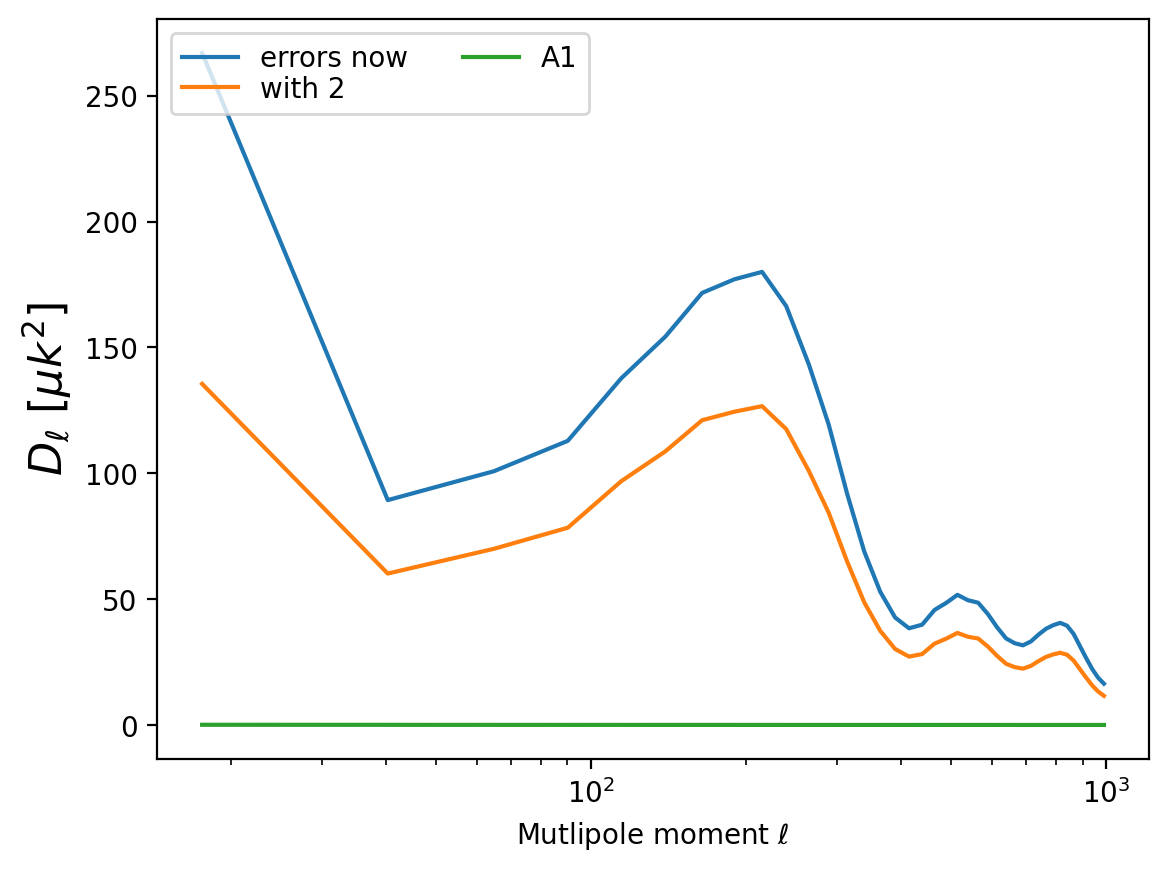

0.38526967


In [32]:
# Plot results
#plt.plot(ell_arr, Db_errors_cVariance, label='cosmic_variance on D_binnedl')
plt.plot(ell_b[0:40], sDb[0:40], label='errors now')
plt.plot(ell_b[0:40], sigma_Db[0:40], label='with 2')
plt.plot(ell_b[0:40], A1[0:40], label='A1')
#plt.plot(ell_arr[0:40], A2[0:40], label='A2')
#plt.plot(ell_arr, a1s, label='a1s')
#plt.plot(ell_arr, a2s, label='a2s')
#plt.plot(ell_arr, a2aas, label='a2aas')
#plt.plot(ell_arr, a2abs**2, label='a2abs**2')
#plt.plot(ell_arr, a2abs, label='a2abs')
#plt.plot(ell_arr, a2bbs, label='a2bbs')
#plt.plot(ell_arr, a2aas*a2bbs, label='a2aas*a2bbs')
#plt.plot(ell_arr, Db_chatGPT, label='GPT')
plt.xscale('log')
plt.xlabel(r'Mutlipole moment $\ell$')
plt.ylabel(r'$D_{\ell}$ $[\mu k^2]$', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()
print(f_sky)

#print('a2abs',min(a2abs), max(a2abs))
#print('a2bbs',min(a2bbs), max(a2bbs))
#print('a2aas',min(a2aas), max(a2aas))

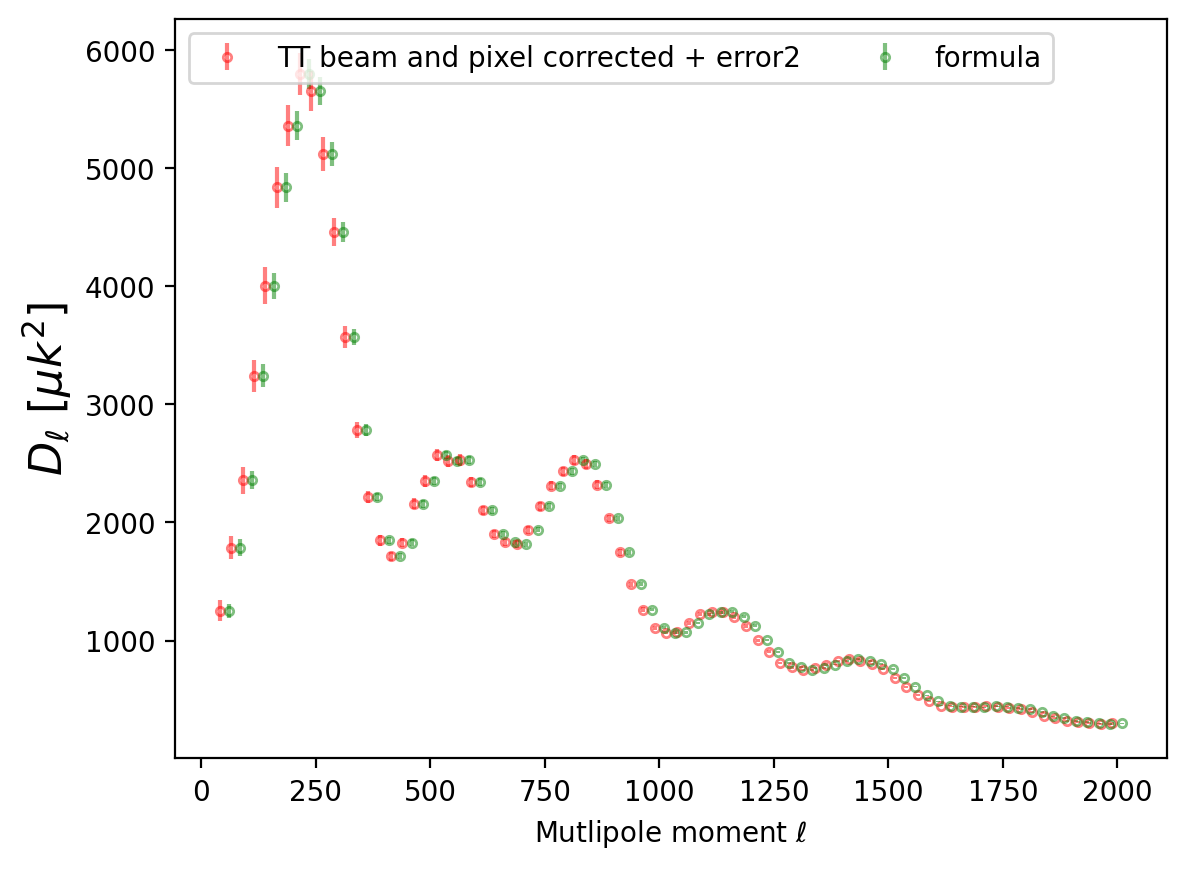

In [33]:
LMAX =80
Lstart=1
plt.errorbar(ell_b[Lstart:LMAX], Db[Lstart:LMAX], yerr=sDb[Lstart:LMAX],capsize=0,color='r',
              fmt='.',markerfacecolor='none', label='TT beam and pixel corrected + error2', alpha =0.5)
plt.errorbar(ell_b[Lstart:LMAX]+20, Db[Lstart:LMAX], yerr=sigma_Db[Lstart:LMAX],capsize=0,color='g',
              fmt='.',markerfacecolor='none', label='formula', alpha =0.5)
#plt.errorbar(ell_arr, Dl_theory_binned,color='k',
#              fmt='.',markerfacecolor='none', label='Theoretical', alpha =0.5)
#plt.xscale('log')
plt.xlabel(r'Mutlipole moment $\ell$')
plt.ylabel(r'$D_{\ell}$ $[\mu k^2]$', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()

For each bin defined by the multipole range $[\ell_{\min}, \ell_{\max}]$, we compute the effective multipole $\ell_b$ as a weighted average over the number of modes:

\begin{equation}
\ell_b = \frac{\sum\limits_{\ell = \ell_{\min}}^{\ell_{\max}} \ell \, (2\ell + 1)}{\sum\limits_{\ell = \ell_{\min}}^{\ell_{\max}} (2\ell + 1)}
\end{equation}

This accounts for the fact that each multipole $\ell$ contains $2\ell + 1$ modes.

\section*{2. Variance of Binned Power Spectrum $C_b$}

Assuming two temperature maps $A$ and $B$, we define the binned power spectrum error using both the cross and auto-spectra as:

$$ \sigma^2(C_b) = \frac{2}{(2\ell_b + 1)\, f_{\mathrm{sky}} \, \Delta\ell} \left[ \left(C_b^{AB}\right)^2 + C_b^{AA} \, C_b^{BB} \right]$$



The power spectrum is often presented in terms of

\begin{equation}
D_\ell = \frac{\ell(\ell + 1)}{2\pi} C_\ell
\end{equation}

For binned spectra, the corresponding $D_b$ and its uncertainty are:

\begin{align}
D_b &= \frac{\ell_b(\ell_b + 1)}{2\pi} C_b \\
\sigma(D_b) &= \frac{\ell_b(\ell_b + 1)}{2\pi} \, \sigma(C_b)
\end{align}


----
### END RESULT:

In [34]:
Final_Db= Db[Lstart:LMAX]
Final_ell_b = ell_b[Lstart:LMAX]
Final_sDb = sigma_Db[Lstart:LMAX]

-----
## Theory CMB

In [36]:
totCL[:,0].shape


(6194,)

In [37]:
target_length = 6194

# Compute how many 1s to add
num_ones_to_add = target_length - len(TT)

TT = np.pad(TT, (0, num_ones_to_add), mode='constant', constant_values=1)

TT.shape

(6194,)

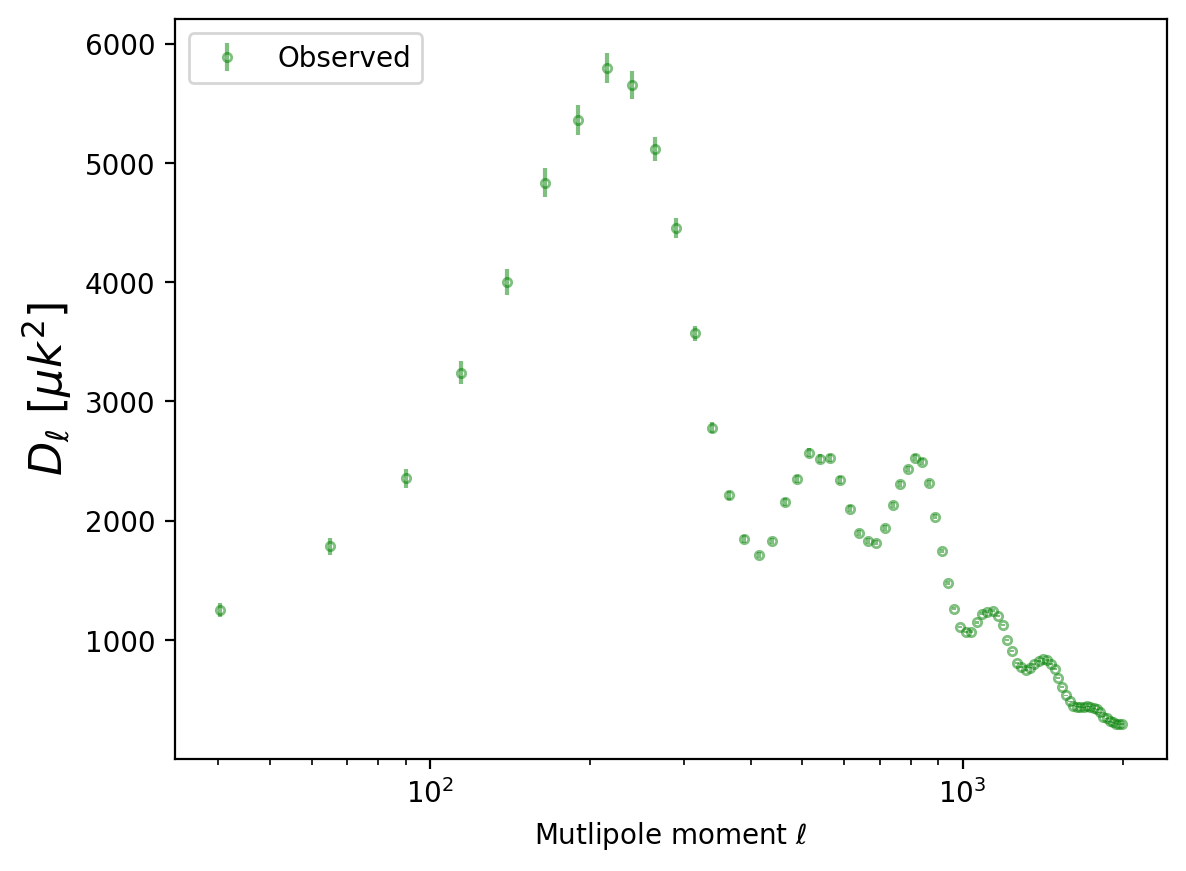

(array([1251.93923309, 1787.1535787 , 2357.35875098, 3240.12196885,
        4003.5271777 , 4835.2026664 , 5359.14483655, 5794.52903973,
        5652.35142518, 5116.03498226, 4457.06658432, 3570.30814429,
        2781.36167085, 2215.14736336, 1847.10503178, 1713.3862402 ,
        1829.83183595, 2157.51809611, 2351.27445517, 2569.64263417,
        2521.0488002 , 2527.56969723, 2342.24002923, 2102.55195725,
        1900.22338606, 1829.97806012, 1815.53787208, 1938.38335298,
        2135.03731102, 2309.26839324, 2433.58336148, 2527.39544423,
        2494.75196923, 2320.14585367, 2033.40840361, 1746.02331816,
        1475.83810662, 1261.53530595, 1109.59621741, 1066.95867862,
        1070.2358286 , 1148.11568623, 1222.89445567, 1239.51021843,
        1244.65240532, 1202.53361429, 1125.36332765, 1002.67836232,
         905.37341755,  810.95343465,  773.04723498,  749.58924255,
         769.57040509,  796.95777797,  826.07145272,  845.45313967,
         829.81570467,  800.41152913,  760.61579

In [ ]:
plt.errorbar(Final_ell_b, Final_Db, yerr=Final_sDb,capsize=0,color='g',
              fmt='.',markerfacecolor='none', label='Observed', alpha =0.5)
#plt.errorbar(Final_ell_b, Final_theory_Db,color='k',
# fmt='.',markerfacecolor='none', label='Theoretical', alpha =0.5)

plt.xscale('log')
plt.xlabel(r'Mutlipole moment $\ell$')
plt.ylabel(r'$D_{\ell}$ $[\mu k^2]$', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()
Final_ell_b

In [39]:
exp_data = np.column_stack((Final_ell_b, Final_Db, Final_sDb))

# Save to CSV
np.savetxt(
    "exp_data.csv",
    exp_data,
    delimiter=",",
    header="Final_ell_b, Final_Db, Final_sDb",
    comments=""
)

-----
## Ok vamo

In [44]:
target_length = 6194

def Get_Db_Theory(Lstart, LMAX, omega_k=0.0, H_0=67.36, ):
    '''Given parameter, Outputs theoretical predicted Db values within the [Lstart:LMAX] range'''
       # Set up parameters
    pars = camb.CAMBparams()  # <--- this is the correct class name
    pars.set_cosmology( H0=H_0,               # Hubble parameter today
        ombh2=0.02237,          # Baryon density parameter
        omch2=0.1200,           # Cold dark matter density parameter
        mnu=0.06,               # Minimal mass for neutrinos (one massive)
        omk=omega_k,            # Curvature — this is what you'll vary in MCMC
        tau=0.0544,             # Reionization optical depth
        )
    pars.InitPower.set_params(As=2.100e-9, ns=0.9649)
    
    # Only calculate scalar TT power spectrum
    pars.WantTensors = False
    pars.WantScalars = True
    pars.WantCls = True
    pars.DoLensing = False
    pars.set_for_lmax(2000, lens_potential_accuracy=0)
    pars.OutputCls = ['T']
    
    # Run CAMB
    results = camb.get_results(pars)
    cls = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    TT = cls['total'][:, 0]  # TT spectrum
    
    # Compute how many 1s to add
    num_ones_to_add = target_length - len(TT)
    TT = np.pad(TT, (0, num_ones_to_add), mode='constant', constant_values=1)


    Dl_theory_full = TT # in micro kelvin ^2

    Dl_theory =np.array(Dl_theory_full[0:lmax+1])
    ell_theory = np.arange(len(Dl_theory))

    Dl_theory_binned = b.bin_cell(Dl_theory)
    
    Final_theory_Db = Dl_theory_binned[Lstart:LMAX]
    return Final_theory_Db

In [50]:
def logP(Db, sDb, Tb):
    '''Calculates the log of the likeyhood up to a normalizing factor'''
    Xi2= ((Db - Tb)/sDb)**2
    return -0.5*Xi2.sum()

In [51]:
#Lstart = 1
#LMAX = 80 

Lstart = 1
LMAX = 16  #these are indicies lb_max=400

Final_Db= Db[Lstart:LMAX]
Final_ell_b = ell_b[Lstart:LMAX]
Final_sDb = sigma_Db[Lstart:LMAX]

In [52]:
%%time

Omg_k = 0.0007
sOmg_k= 0.0019

N=5

#Omegas= np.linspace(Omg_k-5*sOmg_k,  Omg_k+5*sOmg_k , N)
Omegas= np.linspace( -0.0075,0.0080, N)
list_logL_theta=[]

for o in Omegas:
    Test_theory_Db = Get_Db_Theory(Lstart, LMAX, omega_k=o)
    list_logL_theta.append(logP(Final_Db, Final_sDb, Test_theory_Db))
    print(o)
    
arr_logL_theta = np.array(list_logL_theta)

-0.0075
-0.0036249999999999998
0.0002500000000000002
0.004125
0.008
CPU times: user 26.1 s, sys: 124 ms, total: 26.2 s
Wall time: 3.66 s


In [53]:
%%time

H_0 = 67.36
sH_0= 0.5

N=25

Hs= np.linspace(63.5, 72 , N)
list_logL_theta=[]

for h in Hs:
    Test_theory_Db = Get_Db_Theory(Lstart, LMAX,omega_k=Omg_k, H_0=h)
    list_logL_theta.append(logP(Final_Db, Final_sDb, Test_theory_Db))
    
arr_logL_theta = np.array(list_logL_theta)

CPU times: user 2min 10s, sys: 680 ms, total: 2min 11s
Wall time: 18.4 s


In [54]:
import numpy as np
import pandas as pd

-----
## Ok vamo ahora 

In [62]:
%%time
# Define parameter ranges
Omg_k = 0.0007
sOmg_k = 0.0019
H_0 = 67.36
sH_0 = 0.5

N = 100

Omegas = np.linspace(-0.0075,0.0080, N)
Hs = np.linspace(63.5, 72 , N)

# Initialize 2D array to store log-likelihoods
logL_grid = np.zeros((len(Hs), len(Omegas)))

# Compute log-likelihoods
for i, h in enumerate(Hs):
    print((i),'%')
    for j, o in enumerate(Omegas):
        Test_theory_Db = Get_Db_Theory(Lstart, LMAX, omega_k=o, H_0=h)
        logL_grid[i, j] = logP(Final_Db, Final_sDb, Test_theory_Db)

# Create a DataFrame to store the values in a long-form table
rows = []
for i, h in enumerate(Hs):
    for j, o in enumerate(Omegas):
        rows.append({'H_0': h, 'Omega_k': o, 'logL': logL_grid[i, j]})
print('ok!')


likelihood_df = pd.DataFrame(rows)
likelihood_df.to_csv("likelihood_grid.csv", index=False)
print("Saved likelihood grid to likelihood_grid.csv")

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
ok!
Saved likelihood grid to likelihood_grid.csv
CPU times: user 17h 23min 20s, sys: 2min 25s, total: 17h 25min 46s
Wall time: 2h 20min 53s


In [62]:
%%time
# Define parameter ranges
Omg_k = 0.0007
sOmg_k = 0.0019
H_0 = 67.36
sH_0 = 0.5

N = 5

Omegas = np.linspace(-0.0075,0.0080, N)
Hs = np.linspace(63.5, 72 , N)

# Initialize 2D array to store log-likelihoods
logL_grid = np.zeros((len(Hs), len(Omegas)))

# Compute log-likelihoods
for i, h in enumerate(Hs):
    print((i),'%')
    for j, o in enumerate(Omegas):
        Test_theory_Db = Get_Db_Theory(Lstart, LMAX, omega_k=o, H_0=h)
        logL_grid[i, j] = logP(Final_Db, Final_sDb, Test_theory_Db)

# Create a DataFrame to store the values in a long-form table
rows = []
for i, h in enumerate(Hs):
    for j, o in enumerate(Omegas):
        rows.append({'H_0': h, 'Omega_k': o, 'logL': logL_grid[i, j]})
print('ok!')


likelihood_df = pd.DataFrame(rows)
likelihood_df.to_csv("likelihood_grid.csv", index=False)
print("Saved likelihood grid to likelihood_grid_Better.csv")

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
ok!
Saved likelihood grid to likelihood_grid.csv
CPU times: user 17h 23min 20s, sys: 2min 25s, total: 17h 25min 46s
Wall time: 2h 20min 53s


In [6]:
import pandas as pd
import numpy as np
# Load the CSV with the likelihood grid
data = pd.read_csv("likelihood_grid_YAY.csv")

# Extract parameters and log-likelihoods
omega_k_vals = data["Omega_k"].values
H0_vals = data["H_0"].values
logL = data["logL"].values

# # Normalize log-likelihoods to probabilities
# logL -= np.max(logL)  # Prevent overflow
# prob = np.exp(logL)
# 
# # Normalize to make it a proper posterior (integrates to 1)
# prob /= np.sum(prob)


arr_logL_theta= logL
log_probs =arr_logL_theta- np.max(arr_logL_theta)  # now the max log_prob is 0
probs = np.exp(log_probs)                          # no underflow!
increment = (max(Hs)-min(Hs))*(max(Omegas)-min(Omegas))/(N**2)
Volume = np.sum(probs)* (increment)       
Normalized_probs = probs/Volume  

# Create a corner plot using weights (no resampling)
samples = np.vstack([omega_k_vals, H0_vals]).T
figure = corner.corner(
    samples,
    weights=Normalized_probs,
    bins=50,
    labels=[r"$\Omega_k$", r"$H_0$"],
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12},
    color="firebrick",
    plot_density=True,
    fill_contours=True,
    levels=(0.68, 0.95),
    smooth=True
)

plt.show()

NameError: name 'Hs' is not defined

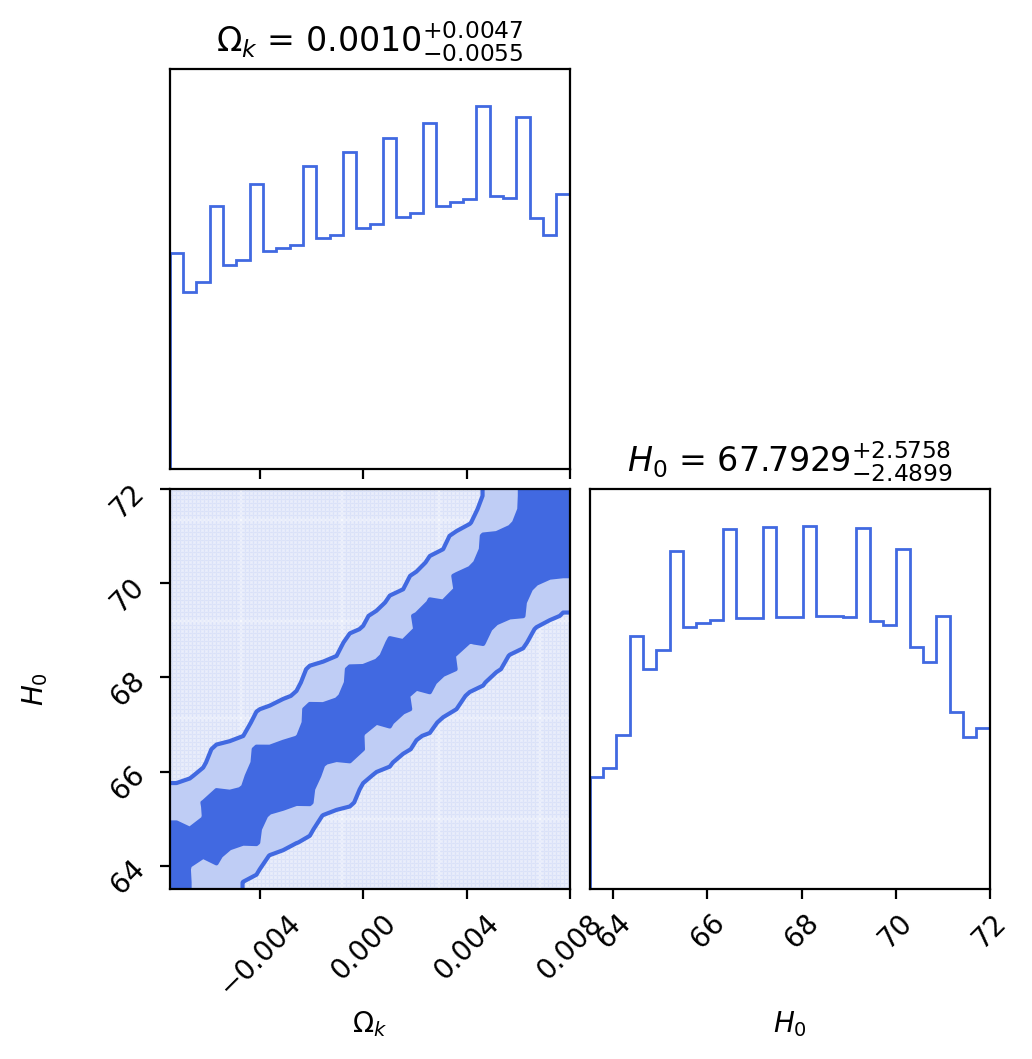

In [78]:

# Load the likelihood grid from file
data = pd.read_csv("likelihood_grid_YAY.csv")

# Normalize log-likelihoods to get posteriors
logL = data['logL'].values
logL -= np.max(logL)  # Avoid underflow
posterior = np.exp(logL)
posterior /= np.sum(posterior)  # Normalize

# Add to dataframe
data['posterior'] = posterior

# Extract Omega_k and H0
omega_k = data['Omega_k'].values
H0 = data['H_0'].values

# Stack the two parameters for corner plot
samples = np.vstack([omega_k, H0]).T

# Weigh samples by posterior for plotting
fig = corner.corner(
    samples,
    weights=posterior,
    bins=30,
    labels=[r"$\Omega_k$", r"$H_0$"],
    show_titles=True,
    title_fmt=".4f",
    plot_density=True,
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95),
    color="royalblue"
)
plt.show()


In [4]:
# Read the CSV file
filename = "likelihood_grid_YAY2.csv"
data = pd.read_csv(filename)

# Extract Omega_k, H0, and logL
omega_k = data['Omega_k'].values
H0 = data['H_0'].values
logL = data['logL'].values

data["H0_times_ok"] = data["H_0"] * np.sqrt(np.abs(1 - data["Omega_k"]))
new=data["H0_times_ok"] 
# Normalize log-likelihoods
logL -= np.max(logL)
P = np.exp(logL)

# Normalize posterior
P /= np.sum(P)

# Construct 2D posterior grid for corner plot
posterior_grid = np.column_stack((omega_k, new))

# Create corner plot using weights (no resampling)
figure = corner.corner(posterior_grid, weights=P, labels=["$\Omega_k$", "$H_0$"],
                       bins=50, smooth=True, smooth1d=True, color="red",
                       label_kwargs={"fontsize": 14})

plt.show()

NameError: name 'pd' is not defined

In [77]:
N=100
(N*73/100)**2/3600, N

(1.4802777777777778, 100)

In [55]:
log_probs =arr_logL_theta- np.max(arr_logL_theta)  # now the max log_prob is 0
probs = np.exp(log_probs)                          # no underflow!
increment = (max(Hs)-min(Hs))/N
Area = np.sum(probs)* (increment)       
Normalized_probs = probs/Area      # normalize if needed

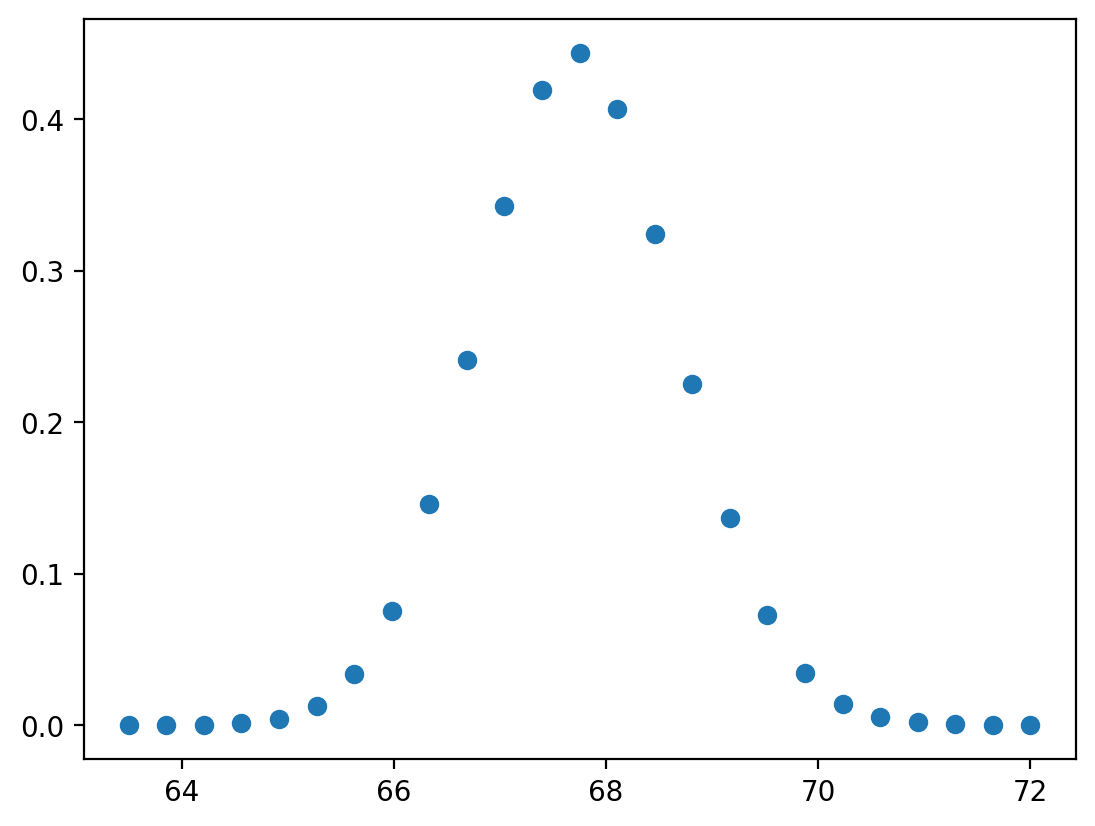

In [56]:
plt.scatter(Hs, Normalized_probs)

ValueError: x and y must be the same size

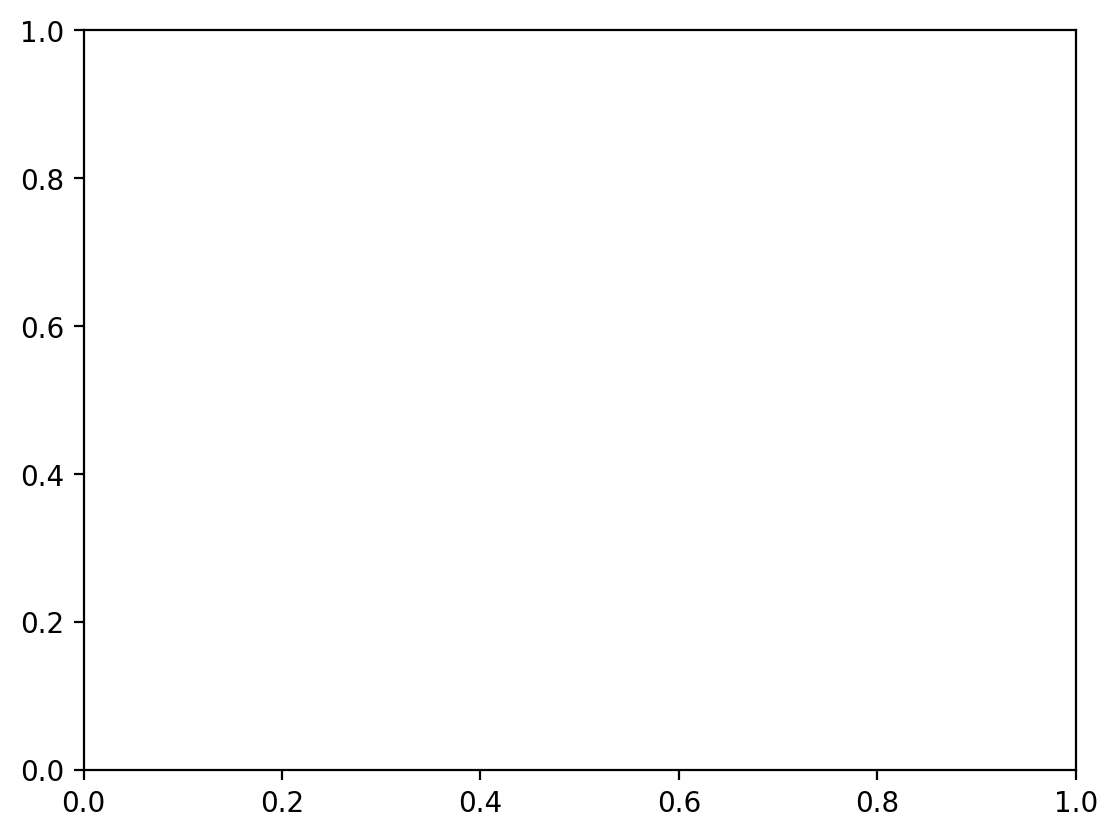

In [68]:
plt.scatter(Omegas, Normalized_probs)

In [408]:
Omg_k-5*sOmg_k, Omg_k+5*sOmg_k

(-0.0088, 0.010199999999999999)

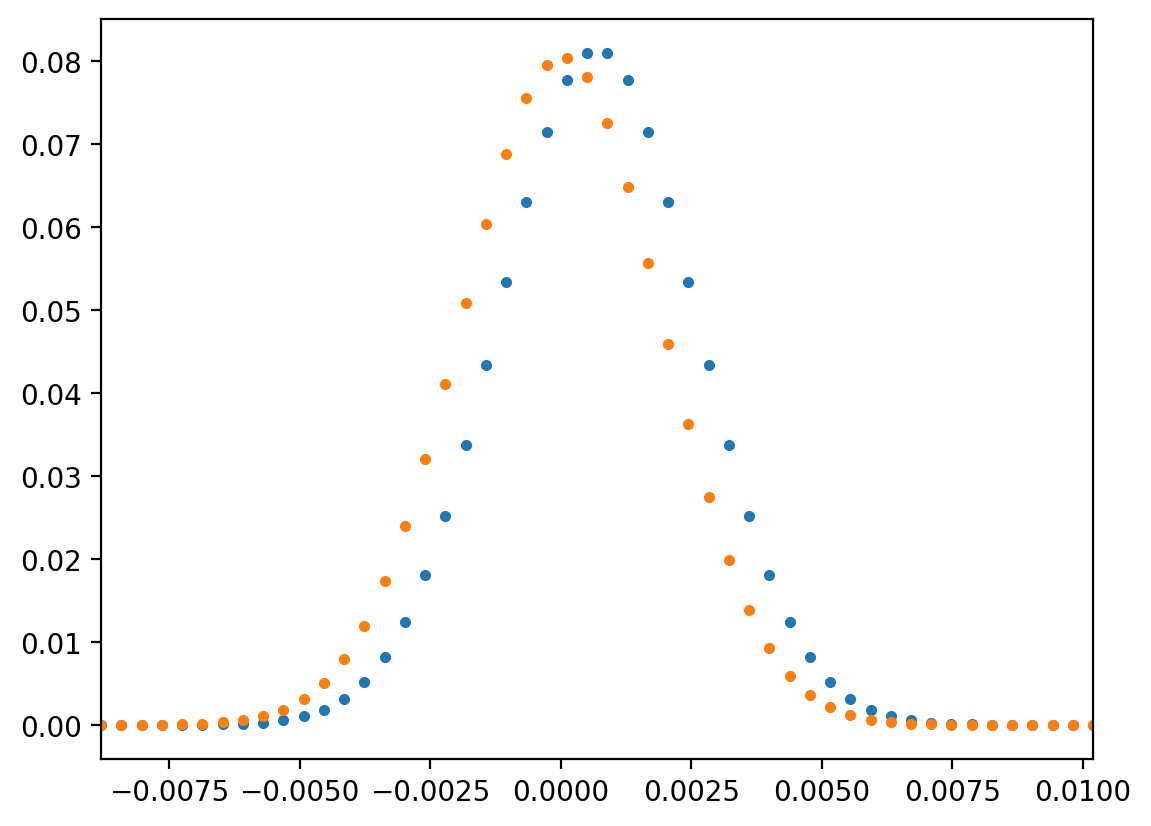

In [409]:
x = np.linspace(mu - 5*sigma, mu + 5*sigma, N)
Planck = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
Normalized_Planck = Planck/np.sum(Planck)          # normalize if needed

plt.plot(x, Normalized_Planck,  '.', label=f'N({mu}, {sigma}²)',)
plt.plot(Omegas, Normalized_probs, '.')
plt.xlim(Omg_k-5*sOmg_k, Omg_k+5*sOmg_k)
plt.show()

$$ds^2 = -dt^2 + a(t)^2\Bigl[\frac{dr^2}{1-k\,r^2} + \dots\Bigr]$$
$$\Omega_k = -\frac{k\,c^2}{(aH)^2}$$

-----
### Ploty Plots

In [69]:
import corner

# Assuming you already have:
# Omega_k_array (shape: N), H0_array (shape: M), logp (shape: N x M)

# 1. Normalize log-likelihood
logp -= np.max(logp)
p = np.exp(logp)

# 2. Create 2D meshgrid of parameter values
Omega_k_grid, H0_grid = np.meshgrid(Omega_k_array, H0_array, indexing='ij')

# 3. Flatten the grids and the probability array
flat_Ok = Omega_k_grid.flatten()
flat_H0 = H0_grid.flatten()
flat_p  = p.flatten()

# 4. Sample points from the distribution using importance sampling
# (Sampling with weights p to generate mock posterior samples)
n_samples = 5000  # or more if needed
samples_idx = np.random.choice(len(flat_p), size=n_samples, p=flat_p/np.sum(flat_p))
samples = np.vstack([flat_Ok[samples_idx], flat_H0[samples_idx]]).T

# 5. Create corner plot
fig = corner.corner(samples,
                    labels=[r"$\Omega_k$", r"$H_0$ [km/s/Mpc]"],
                    truths=[None, None],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_fmt=".3f",
                    smooth=1.0,
                    color='royalblue')

plt.show()

NameError: name 'logp' is not defined

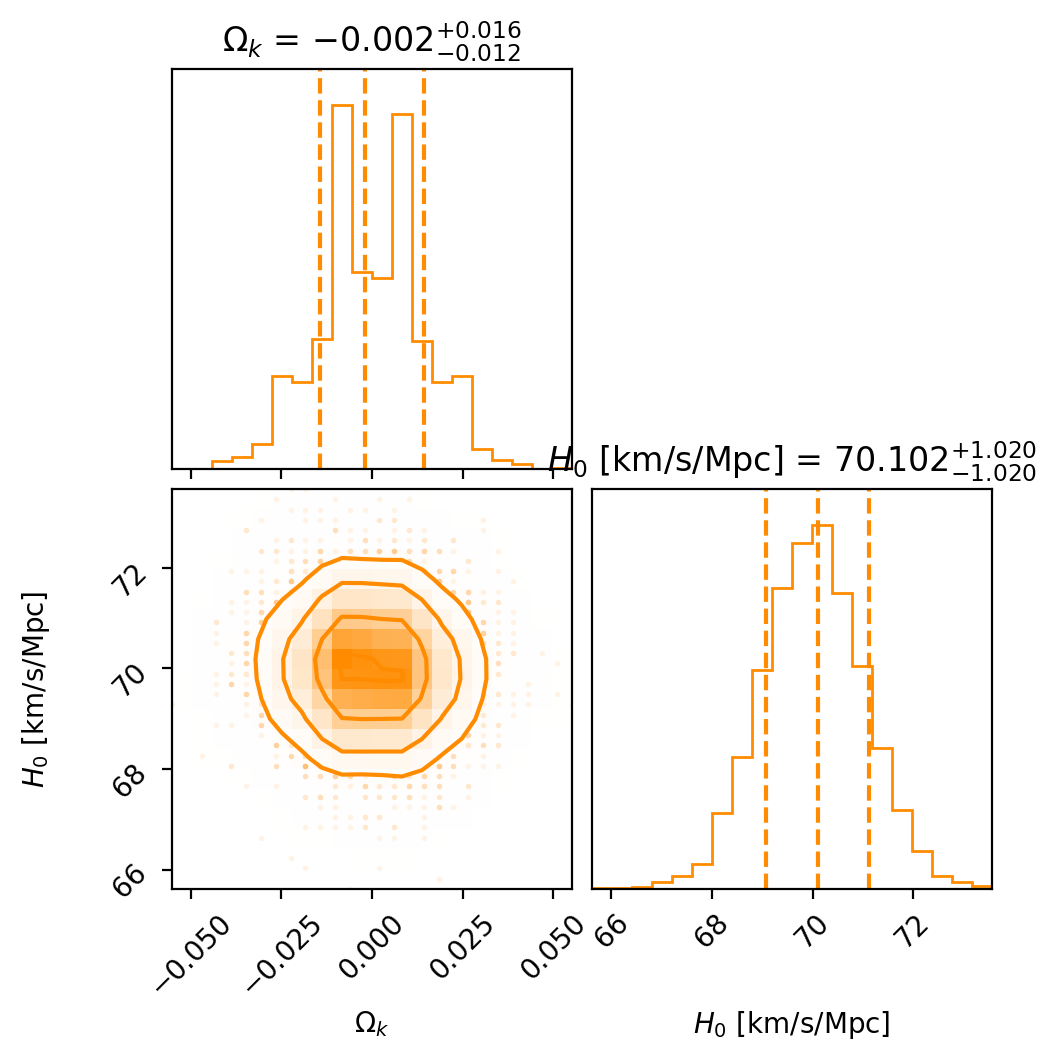

In [415]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# Step 1: Define 1D arrays of parameter values
Omega_k_array = np.linspace(-0.1, 0.1, 50)   # example range for Omega_k
H0_array = np.linspace(65, 75, 50)           # example range for H0 in km/s/Mpc

# Step 2: Create a dummy 2D log-likelihood surface (a 2D Gaussian here for illustration)
Omega_k_grid, H0_grid = np.meshgrid(Omega_k_array, H0_array, indexing='ij')
logp = -((Omega_k_grid / 0.02)**2 + ((H0_grid - 70) / 1.5)**2)  # log posterior ∝ -χ²

# Step 3: Convert log-likelihood to probability
logp -= np.max(logp)
p = np.exp(logp)

# Step 4: Flatten and sample points from the 2D grid
flat_Ok = Omega_k_grid.flatten()
flat_H0 = H0_grid.flatten()
flat_p = p.flatten()
samples_idx = np.random.choice(len(flat_p), size=5000, p=flat_p/np.sum(flat_p))
samples = np.vstack([flat_Ok[samples_idx], flat_H0[samples_idx]]).T

# Step 5: Corner plot
fig = corner.corner(samples,
                    labels=[r"$\Omega_k$", r"$H_0$ [km/s/Mpc]"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_fmt=".3f",
                    smooth=1.0,
                    color='darkorange')

plt.show()


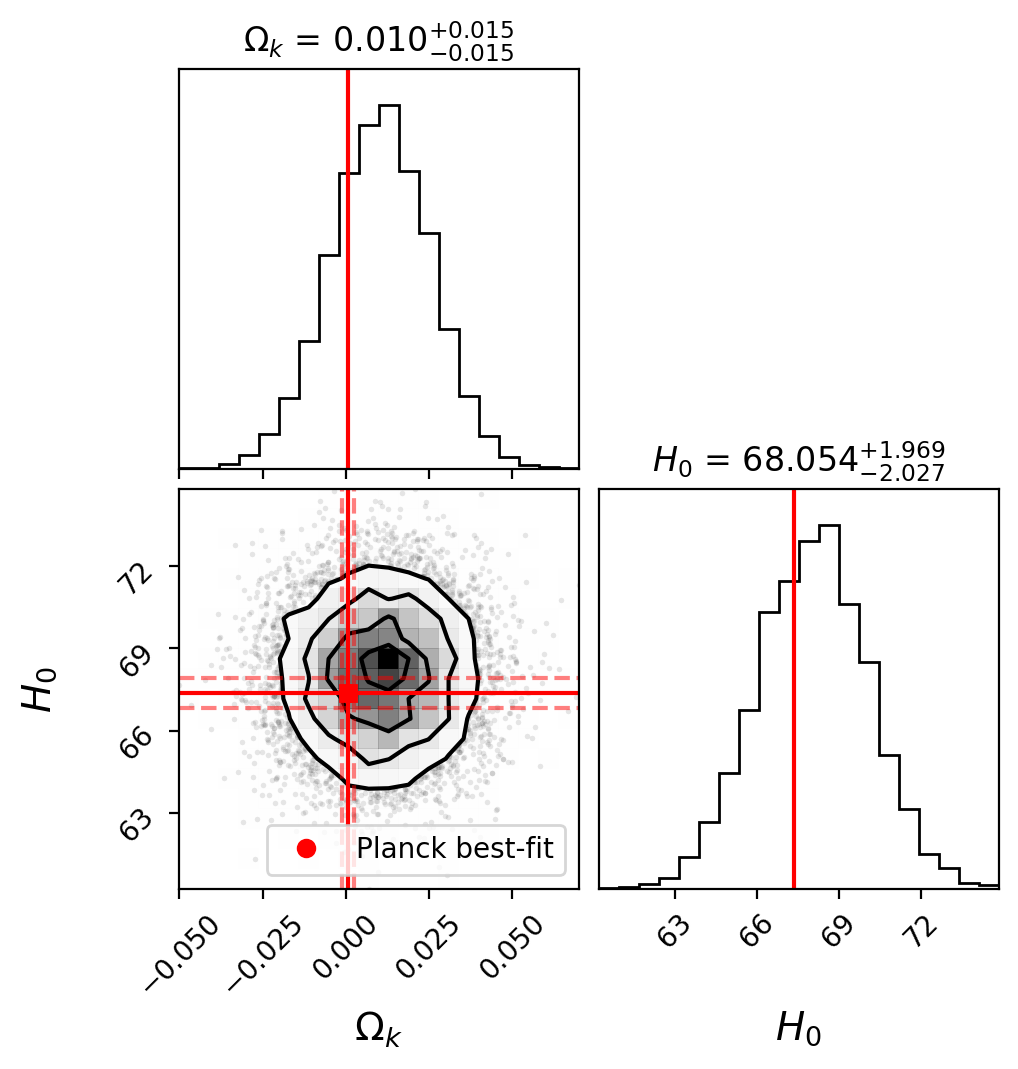

In [421]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# Your data (e.g., samples from likelihood surface)
# Let's simulate mock samples
omega_k_samples = np.random.normal(loc=0.01, scale=0.015, size=10000)
H0_samples = np.random.normal(loc=68, scale=2, size=10000)

samples = np.vstack([omega_k_samples, H0_samples]).T

# Planck best-fit values (example)
planck_omega_k = 0.0007
planck_H0 = 67.36
planck_std_omega_k = 0.0019
planck_std_H0 = 0.54

# Create corner plot
figure = corner.corner(samples,
                       labels=[r"$\Omega_k$", r"$H_0$"],
                       truths=[planck_omega_k, planck_H0],  # reference values (shown as dashed lines)
                       truth_color='red',
                       label_kwargs={"fontsize": 14},
                       show_titles=True,
                       title_fmt=".3f")

# Plot Planck point as red dot
axes = np.array(figure.axes).reshape((2, 2))
axes[1, 0].plot(planck_omega_k, planck_H0, 'ro', label='Planck best-fit')

# Add Planck 1σ crosshairs (optional)
axes[1, 0].axhline(planck_H0 - planck_std_H0, color='red', ls='--', alpha=0.5)
axes[1, 0].axhline(planck_H0 + planck_std_H0, color='red', ls='--', alpha=0.5)
axes[1, 0].axvline(planck_omega_k - planck_std_omega_k, color='red', ls='--', alpha=0.5)
axes[1, 0].axvline(planck_omega_k + planck_std_omega_k, color='red', ls='--', alpha=0.5)

axes[1, 0].legend()

plt.show()


In [422]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=1, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on a covariance matrix `cov`
    centered at position `pos`.
    """
    from scipy.stats import chi2

    if ax is None:
        ax = plt.gca()

    # Eigen decomposition
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Width, height = 2*sqrt(eigenvalues*chisq)
    chi2_val = chi2.ppf(0.6827 if nstd == 1 else 0.9545, df=2)  # 1σ or 2σ
    width, height = 2 * np.sqrt(vals * chi2_val)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    ellip = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellip)
    return ellip


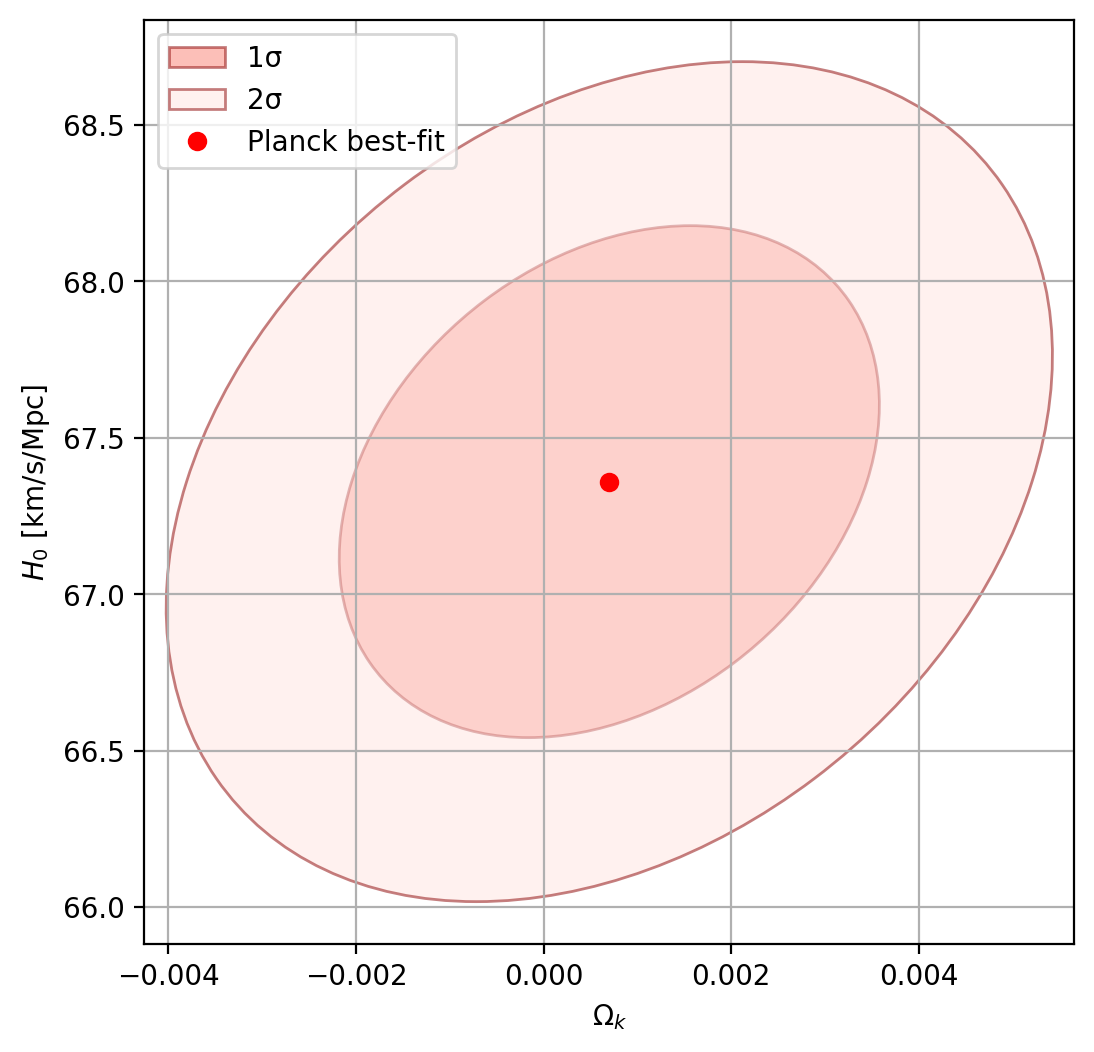

In [423]:
# Planck best-fit means
omega_k_0 = 0.0007
H0_0 = 67.36

# Approximate covariance matrix (Ω_k, H0) [units: dimensionless, km/s/Mpc]
# This assumes ~0.0019 std in Ω_k, ~0.54 in H0, and slight positive correlation
std_omega_k = 0.0019
std_H0 = 0.54
rho = 0.3  # correlation coefficient

cov = np.array([
    [std_omega_k**2, rho * std_omega_k * std_H0],
    [rho * std_omega_k * std_H0, std_H0**2]
])

# Create plot
fig, ax = plt.subplots(figsize=(6,6))

# Plot ellipses
plot_cov_ellipse(cov, (omega_k_0, H0_0), nstd=1, ax=ax, edgecolor='darkred', facecolor='salmon', alpha=0.5, label='1σ')
plot_cov_ellipse(cov, (omega_k_0, H0_0), nstd=2, ax=ax, edgecolor='darkred', facecolor='mistyrose', alpha=0.5, label='2σ')

# Mark Planck point
ax.plot(omega_k_0, H0_0, 'ro', label='Planck best-fit')

# Axis labels and legend
ax.set_xlabel(r"$\Omega_k$")
ax.set_ylabel(r"$H_0$ [km/s/Mpc]")
ax.legend()
ax.grid(True)

plt.show()


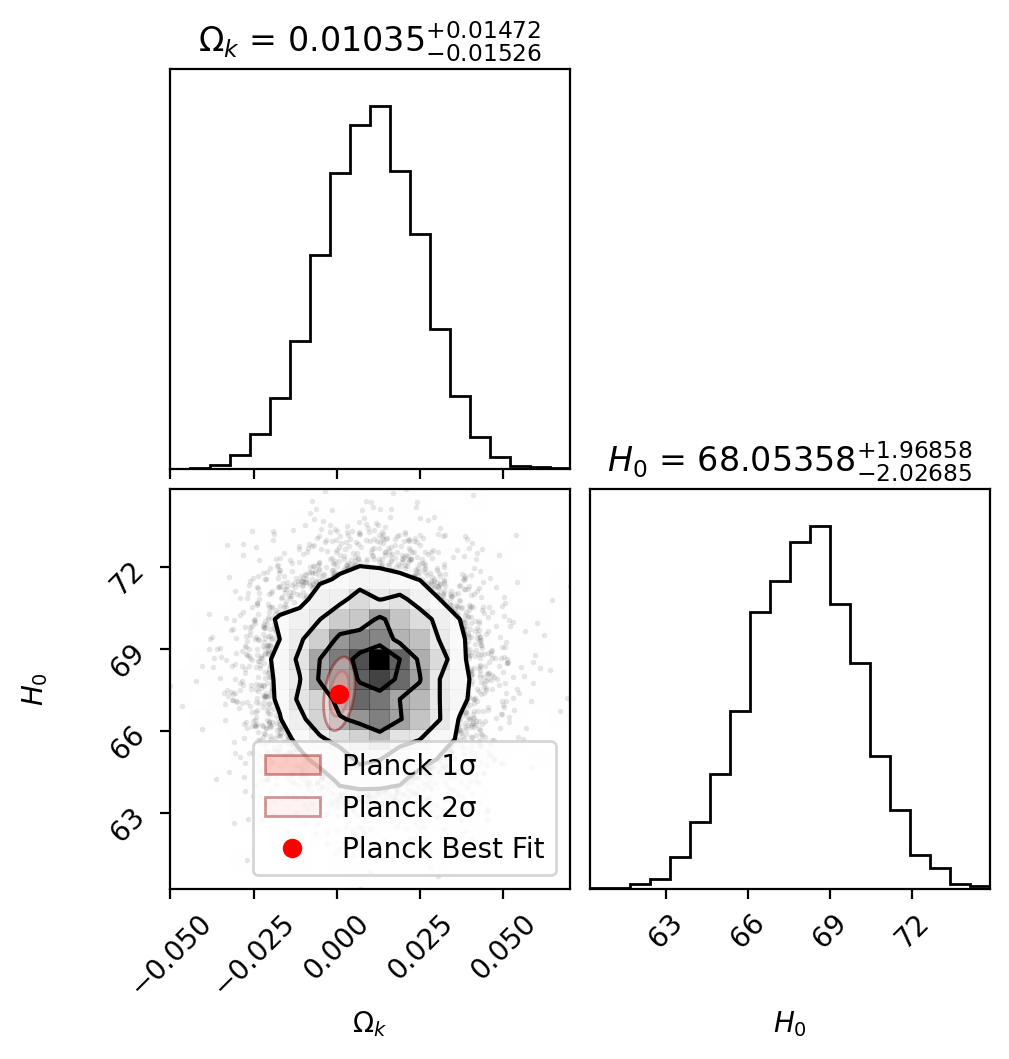

In [424]:
import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def plot_cov_ellipse(cov, pos, ax, nstd=1, **kwargs):
    """
    Plot a 1σ or 2σ ellipse on a given corner plot axis.
    """
    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Size of the ellipse corresponding to desired confidence interval
    chi2_val = chi2.ppf(0.6827 if nstd == 1 else 0.9545, df=2)
    width, height = 2 * np.sqrt(vals * chi2_val)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    ellip = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellip)

# Example posterior samples
# samples = np.column_stack([omega_k_samples, H0_samples])

fig = corner.corner(samples, labels=[r"$\Omega_k$", r"$H_0$"], 
                    show_titles=True, title_fmt=".5f")

# Planck best-fit values
omega_k_0 = 0.0007
H0_0 = 67.36

# Estimate of covariance matrix
std_omega_k = 0.0019
std_H0 = 0.54
rho = 0.3  # estimated correlation
cov = np.array([
    [std_omega_k**2, rho * std_omega_k * std_H0],
    [rho * std_omega_k * std_H0, std_H0**2]
])

# Access the subplot for the 2D distribution (lower triangle: (1,0) if 2D)
axes = np.array(fig.axes).reshape((2, 2))  # works only if plotting 2 parameters
ax_2d = axes[1, 0]

# Overlay 1σ and 2σ ellipses
plot_cov_ellipse(cov, (omega_k_0, H0_0), ax=ax_2d, nstd=1,
                 edgecolor='darkred', facecolor='salmon', alpha=0.4, label='Planck 1σ')
plot_cov_ellipse(cov, (omega_k_0, H0_0), ax=ax_2d, nstd=2,
                 edgecolor='darkred', facecolor='mistyrose', alpha=0.4, label='Planck 2σ')

# Add Planck best-fit marker
ax_2d.plot(omega_k_0, H0_0, 'ro', label='Planck Best Fit')

# Add legend manually
ax_2d.legend()

plt.show()
